In [1]:
# https://towardsdatascience.com/yolo-v3-object-detection-with-keras-461d2cfccef6
# https://github.com/christienatashiaarchie/YOLOv3-Object-Detection/blob/master/Yolov3.ipynb

import os
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import struct
import cv2
from numpy import expand_dims
import tensorflow as tf
from skimage.transform import resize
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')
 
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
 
	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))
 
	def reset(self):
		self.offset = 0

In [3]:
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

In [4]:
# define the yolo v3 model
yolov3 = make_yolov3_model()

# load the weights
weight_reader = WeightReader('models/yolov3.weights')

# set the weights
weight_reader.load_weights(yolov3)

# save the model to file
yolov3.save('models/yolov3_model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [5]:
def load_image_pixels(filename, shape):
  # load image to get its shape
  image = load_img(filename)
  width, height = image.size

  # load image with required size
  image = load_img(filename, target_size=shape)
  image = img_to_array(image)

  # grayscale image normalization
  image = image.astype('float32')
  image /= 255.0

  # add a dimension so that we have one sample
  image = expand_dims(image, 0)
  return image, width, height

In [6]:
class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
    self.xmin = xmin
    self.ymin = ymin
    self.xmax = xmax
    self.ymax = ymax
    self.objness = objness
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label(self):
    if self.label == -1:
      self.label = np.argmax(self.classes)
    
    return self.label
  
  def get_score(self):
    if self.score == -1:
      self.score = self.classes[self.get_label()]
    return self.get_score

def _sigmoid(x):
  return 1. /(1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [7]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [8]:

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
  
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='red', linewidth = '2')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='red')
	# show the plot
	pyplot.show()

In [9]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.6

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.99158382415771 (250, 191, 765, 806)


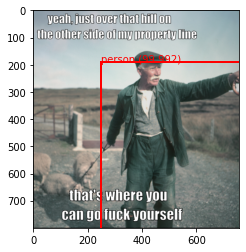

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


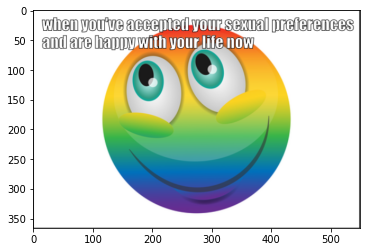

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.8962938785553 (33, 85, 513, 365)


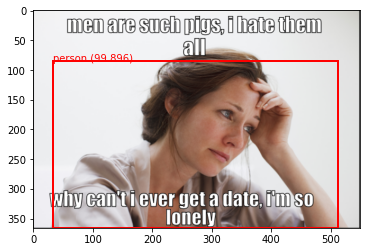

In [10]:
for ph in os.listdir('../facebook_challenge_data/img/')[:3]:
    photo_filename='../facebook_challenge_data/img/' + ph

    # define the expected input shape for the model
    input_w, input_h = 416, 416

    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

    # make prediction
    yhat = yolov3.predict(image)
    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])

    boxes = list() 
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

    # suppress non-maximal boxes
    do_nms(boxes, 0.5)

    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

    # summarize what we found
    for i in range(len(v_boxes)):
        print(v_labels[i], v_scores[i], (v_boxes[i].xmin, v_boxes[i].ymin, v_boxes[i].xmax, v_boxes[i].ymax))

    # draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [11]:
print(type(yhat))
print(len(yhat))
print(yhat[0].shape)
print(yhat[1].shape)
print(yhat[2].shape)


<class 'list'>
3
(1, 13, 13, 255)
(1, 26, 26, 255)
(1, 52, 52, 255)


In [12]:
!nvidia-smi

Sun Jul 26 23:38:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000001:00:00.0 Off |                    0 |
| N/A   63C    P0    63W / 149W |  10944MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000002:00:00.0 Off |                    0 |
| N/A   

In [13]:
yolov3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
______________________________________________________________________________________________

bnorm_63 (BatchNormalization)   (None, None, None, 5 2048        conv_63[0][0]                    
__________________________________________________________________________________________________
leaky_63 (LeakyReLU)            (None, None, None, 5 0           bnorm_63[0][0]                   
__________________________________________________________________________________________________
conv_64 (Conv2D)                (None, None, None, 1 4718592     leaky_63[0][0]                   
__________________________________________________________________________________________________
bnorm_64 (BatchNormalization)   (None, None, None, 1 4096        conv_64[0][0]                    
__________________________________________________________________________________________________
leaky_64 (LeakyReLU)            (None, None, None, 1 0           bnorm_64[0][0]                   
__________________________________________________________________________________________________
add_19 (Ad

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import OrderedDict
import numpy as np
import os
import pickle
import json
import re
from PIL import Image

In [15]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [16]:
# create giant dictionary for all data
data_dir = '../facebook_challenge_data/'
model_dir = 'models/'

def get_dict(path):
    data_dict = OrderedDict()
    jsonl_content = open(path, 'r').read()
    data = [json.loads(jline) for jline in jsonl_content.split('\n')]
    for datum in data: data_dict[datum['id']] = datum
    return data_dict

train_dict = get_dict(data_dir + 'train.jsonl')
val_dict = get_dict(data_dir + 'dev.jsonl')
test_dict = get_dict(data_dir + 'test.jsonl')

print(len(train_dict))
print(len(val_dict))
print(len(test_dict))

8500
500
1000


In [17]:
from random import randint # for random cropping
from tensorflow.keras.preprocessing.sequence import pad_sequences

class FBMMDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_dict, tokenizer, pad_len, batch_size=32, dim=(299, 299), 
                 n_channels=3, shuffle=True, test=False):
        'Initialization'
        self.dim = dim
        self.data_dict = data_dict
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.pad_len = pad_len
        self.tokenizer = tokenizer
        
        # build labels list and id list
        self.id_list = list(self.data_dict.keys())
        self.img_list = {ID: self.data_dict[ID]['img'] for ID in self.id_list}
        if test: self.labels = {ID: 0 for ID in self.id_list}
        else: self.labels = {ID: self.data_dict[ID]['label'] for ID in self.id_list}
            
        # get text dictionary
        self.text_dict = self.process_text(self.id_list)
        
        self.on_epoch_end()
        self.classes = [self.labels[self.id_list[i]] for i in self.indexes]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size)) + 1 # last batch is partial

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.batch_size]
        
        
        # Find list of IDs
        id_list_temp = [self.id_list[k] for k in indexes]

        # Generate data
        X_txt, X_img, X_img_resnet, y = self.__data_generation(id_list_temp)
        
        return (X_txt, X_img, X_img_resnet), y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, id_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X_img = np.empty((len(id_list_temp), *self.dim, self.n_channels))
        X_img_resnet = np.empty((len(id_list_temp), *(224, 224), self.n_channels))
        X_txt = np.empty((len(id_list_temp), self.pad_len))
        y = np.empty(len(id_list_temp), dtype=int)

        # Generate data
        for i, ID in enumerate(id_list_temp):
            # Store sample
            X_img[i,] = self.process_img(data_dir + self.img_list[ID], self.dim)
            X_img_resnet[i,] = self.process_img(data_dir + self.img_list[ID], (224, 224))
            X_txt[i,] = self.text_dict[ID]

            # Store class
            y[i] = self.labels[ID]

        return X_txt.astype(int), X_img, X_img_resnet, y
    
    def process_img(self, path, dim): # method for getting image
        im, image_w, image_h = load_image_pixels(photo_filename, (dim[0], dim[1]))
        
        return im
    
#     def augment(self, im): # random crop and random mirror
        
#         # random crop
#         x_max, y_max = im.shape[0], im.shape[1]
#         x_start, y_start = randint(0, x_max - self.dim[0]), randint(0, y_max - self.dim[1])
#         im = im[x_start:x_start + self.dim[0], y_start:y_start + self.dim[1]]
        
#         # random mirror
#         if randint(0,1): im = np.flip(im, axis=1)
        
#         return im
    
    def process_text(self, id_list):
        
        # matrix for texts
        texts = [self.data_dict[ID]['text'] for ID in id_list]
        sequences = [self.tokenizer.encode(text) for text in texts] # make this more efficient...
        text_seqs = pad_sequences(sequences, maxlen=self.pad_len)
        
        id_to_seq = {ID: txt for (ID, txt) in zip(id_list, text_seqs)} # map id to text seq
        
        return id_to_seq

In [18]:
from transformers import AutoConfig, AutoTokenizer, TFRobertaModel
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
# tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
max_len = 88

batch_size = 32

# create data generators
train_gen = FBMMDataGenerator(data_dict=train_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(416, 416),
                          n_channels=3,
                          shuffle=True)

val_gen = FBMMDataGenerator(data_dict=val_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(416, 416),
                          n_channels=3,
                          shuffle=True)

max len: 87 ; avg len: 16.419529411764707


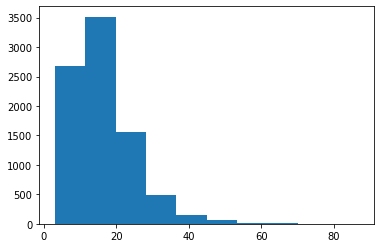

In [19]:
lens = [len(tokenizer.encode(v['text'])) for v in train_dict.values()]
plt.hist(lens)
print('max len:', max(lens), '; avg len:', sum(lens)/len(lens))

# Define model

In [20]:
import transformers
from tensorflow.keras import layers

class BERT(transformers.TFRobertaModel):
    def __init__(self, config, *inputs, **kwargs):
        super(BERT, self).__init__(config, *inputs, **kwargs)
        self.roberta.call = tf.function(self.roberta.call)


class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.resnet = tf.keras.applications.ResNet152V2(include_top=False, 
                                                             weights='imagenet', 
                                                             input_shape=(224, 224, 3))
        for layer in self.resnet.layers[:-1]: layer.trainable = False # freeze resnet
        
        self.bert = BERT.from_pretrained('roberta-base')
        self.yolov3 = yolov3
        for layer in yolov3.layers: layer.trainable = False
        
        self.text_embedding = self.bert.get_input_embeddings().word_embeddings
         
        self.pooling_13 = layers.MaxPooling2D(pool_size=(5, 5), padding='same')
        self.pooling_26 = layers.MaxPooling2D(pool_size=(9, 9), padding='same')
        self.pooling_52 = layers.MaxPooling2D(pool_size=(18, 18), padding='same')
        self.reshape_13 = layers.Reshape((3 * 3, 255)) # 4 = 13//4 + 1
        self.reshape_26 = layers.Reshape((3 * 3, 255)) # 4 = 26//7 + 1
        self.reshape_52 = layers.Reshape((3 * 3, 255)) # 4 = 52//13
        self.W_n = layers.Dense(self.bert.config.hidden_size)
        
        # for resnet
        self.pooling_resnet = layers.AveragePooling2D(pool_size=(2, 2), padding='same')
        self.reshape_resnet = layers.Reshape((4 * 4, 2048)) # 3 is from 7//2
        self.W_ns = [layers.Dense(self.bert.config.hidden_size) for _ in range(self.reshape_resnet.target_shape[0])]
        
        self.reshape_img_emb = layers.Reshape((3*3*3, self.bert.config.hidden_size))
        
        self.concat = layers.Concatenate(axis=1)
        
        self.text_dropout = layers.Dropout(0.2)
        self.image_dropout = layers.Dropout(0.2)
        self.resnet_dropout = layers.Dropout(0.2)
        
        self.dropout = layers.Dropout(0.1)
        self.denseout = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        text, image, image_resnet = inputs
        
        # handle image classes
        yhat = self.yolov3(image)
        preds13, preds26, preds52 = yhat
        # do max pooling so that each has shape (4, 4, 225)
        preds13, preds26, preds52 = self.pooling_13(preds13), self.pooling_26(preds26), self.pooling_52(preds52)
        # reshape so each has shape (16, 255)
        preds13, preds26, preds52 = self.reshape_13(preds13), self.reshape_26(preds26), self.reshape_52(preds52)
        # map to diff bert dimension (16, 768)
        preds13, preds26, preds52 = self.W_n(preds13), self.W_n(preds26), self.W_n(preds52)
        image_emb = tf.keras.backend.stack([preds13, preds26, preds52], axis=1)
        image_emb = self.reshape_img_emb(image_emb)
        # print(image_emb.shape) # gives (None, 48, 768)
        
        # handle image
        image_resnet = tf.keras.applications.resnet_v2.preprocess_input(image_resnet)
        image_emb_resnet = self.resnet(image_resnet)
        image_emb_resnet = self.pooling_resnet(image_emb_resnet)
        image_emb_resnet = self.reshape_resnet(image_emb_resnet)
        image_embeds_resnet = [self.W_ns[i](image_emb_resnet[:, i]) for i in range(self.reshape_resnet.target_shape[0])]
        image_emb_resnet = tf.keras.backend.stack(image_embeds_resnet, axis=1)
        
        # handle text
        text_emb = tf.gather(self.text_embedding, text)
        
        # concat and feed to bert
        text_emb, image_emb, image_emb_resnet = self.text_dropout(text_emb), self.image_dropout(image_emb), self.resnet_dropout(image_emb_resnet)
        concat_emb = self.concat([text_emb, image_emb, image_emb_resnet])
        seg_ids = np.concatenate((np.zeros(max_len, dtype=np.int64), 
                                  np.zeros(self.reshape_img_emb.target_shape[0] + self.reshape_resnet.target_shape[0], dtype=np.int64)))
        bert_encodings = self.bert(inputs={'inputs_embeds': concat_emb,
                                                'token_type_ids': seg_ids})[0]
        doc_encoding = tf.squeeze(bert_encodings[:, 0:1, :], axis=1)
        doc_encoding = self.dropout(doc_encoding)
        output = self.denseout(doc_encoding)
        
        return output

model = MyModel()

Some weights of the model checkpoint at roberta-base were not used when initializing BERT: ['lm_head']
- This IS expected if you are initializing BERT from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BERT from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of BERT were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use BERT for predictions without further training.


In [21]:
optimizer = tf.keras.optimizers.Adam(lr=5e-6)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [22]:
# train model
from tensorflow.keras.callbacks import ModelCheckpoint

weight_file = 'visbert_bt_resnet_weights_fb.h5'

mcp_save = ModelCheckpoint(model_dir + weight_file, 
                           save_weights_only=True, 
                           save_best_only=True, 
                           verbose=1,
                           monitor='val_auc', 
                           mode='max')

history = model.fit(train_gen,
                    validation_data=val_gen,
                    shuffle=True,
                    epochs=15,
                    callbacks=[mcp_save])

Epoch 1/15
266/266 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.6324 - auc: 0.5136
Epoch 00001: val_auc improved from -inf to 0.53270, saving model to models/visbert_bt_resnet_weights_fb.h5
266/266 [==============================] - 902s 3s/step - loss: 0.6686 - accuracy: 0.6324 - auc: 0.5136 - val_loss: 0.7320 - val_accuracy: 0.5000 - val_auc: 0.5327
Epoch 2/15
266/266 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.6366 - auc: 0.5302
Epoch 00002: val_auc did not improve from 0.53270
266/266 [==============================] - 880s 3s/step - loss: 0.6637 - accuracy: 0.6366 - auc: 0.5302 - val_loss: 0.7296 - val_accuracy: 0.5000 - val_auc: 0.4980
Epoch 3/15
266/266 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.6413 - auc: 0.5265
Epoch 00003: val_auc improved from 0.53270 to 0.53751, saving model to models/visbert_bt_resnet_weights_fb.h5
266/266 [==============================] - 891s 3s/step - loss: 0.6604 - ac

In [23]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Model)          (None, 7, 7, 2048)        58331648  
_________________________________________________________________
bert (BERT)                  multiple                  124645632 
_________________________________________________________________
model (Model)                [(None, None, None, 255), 62001757  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 multiple                  0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 multiple                  0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
reshape (Reshape)            multiple                  0  

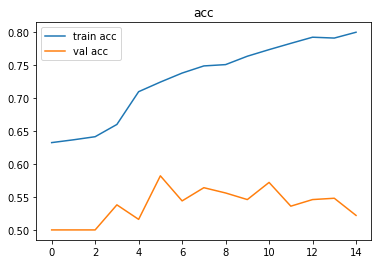

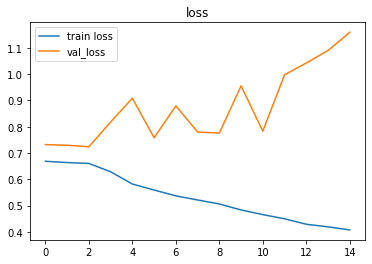

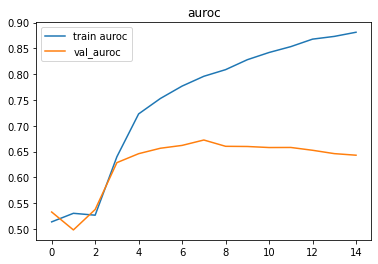

In [24]:
plt.plot(history.history['accuracy'], label = 'train acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.title('acc')
plt.show()

plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.title('loss')
plt.show()

plt.plot(history.history['auc'], label = 'train auroc')
plt.plot(history.history['val_auc'], label = 'val_auroc')
plt.legend()
plt.title('auroc')
plt.show()

In [25]:
model.load_weights(model_dir + weight_file)

In [26]:
val_gen = FBMMDataGenerator(data_dict=val_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(416, 416),
                          n_channels=3,
                          shuffle=True)

In [27]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import math

y_val = val_gen.classes

# get AUROC
val_preds = model.predict(val_gen)
print('Val AUROC:', roc_auc_score(y_val, val_preds))

# get optimal threhold
mx, thresh = 0, 0
preds_bin = np.array(val_preds)

for t in np.linspace(0, 1, 101):
    preds_bin[val_preds >= t] = 1
    preds_bin[val_preds < t] = 0
    acc = accuracy_score(y_val, preds_bin)
    if acc > mx: mx, thresh = acc, t
        
# print(thresh)

# get loss and acc
preds_bin = np.array(val_preds)
preds_bin[val_preds>thresh] = 1
preds_bin[val_preds<=thresh] = 0
print('Val Accuracy:', accuracy_score(y_val, preds_bin))

# get F1
print('Test F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_val, preds_bin, zero_division=1))

Val AUROC: 0.672264
Val Accuracy: 0.644
Test F1: 0.6866197183098591
Test Precision: 0.6132075471698113
Test Recall: 0.78


In [28]:
test_gen = FBMMDataGenerator(data_dict=test_dict,
                          tokenizer=tokenizer,
                          pad_len=max_len,
                          batch_size=batch_size,
                          dim=(416, 416),
                          n_channels=3,
                          shuffle=False,
                          test=True)

ids = test_gen.id_list

preds = model.predict(test_gen)
preds = np.squeeze(preds)

preds_bin = np.array(preds)
preds_bin[preds >= thresh] = 1
preds_bin[preds < thresh] = 0

# write to csv
import csv

with open('visbert_submission.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(["id", "proba", "label"])
    for ID, prob, lab in zip(ids, preds, preds_bin):
        wr.writerow([ID, prob, int(lab)])